In [13]:
import os

experiment_path = './data/Map Experiment #9'

if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)

: 

In [14]:
from map_maker import cluttered_map, save_map
from Turtlebot_Kinematics import unicycleKin
from environment import Environment, load_ENV
from Runner import ControllMode, Runner
from pso_controller import Multi_PSO_Controller
from dwa_controller import DWA_Controller

kinematic = unicycleKin()
run_len = 31
dt = 0.1
max_index = None

# map parameters
map_obs = 8
map_size = 50
map_unknown = True
map_name = f"cluttered_{map_obs}obs_{map_size}x{map_size}_{'unknown' if map_unknown else 'known'}"

for i in range(run_len):
    run_path = f"{experiment_path}/{i}"
    if not os.path.exists(run_path):
        os.makedirs(run_path)

    run_map = cluttered_map(map_obs, map_size, map_unknown)
    map_path = f"{run_path}/{map_name}"
    save_map(run_map, map_name, run_path)


    # run and save long MultiPSO data
    long_MultiPSO_ENV = Environment.from_dict(run_map, kinematic, record=True)
    long_MultiPSO_controller = Multi_PSO_Controller(5, kinematic, 10, 0.75, 10)
    if max_index is None:
        max_index = long_MultiPSO_ENV.goal_travel_time / dt + 200
    else: max_index = max(max_index, long_MultiPSO_ENV.goal_travel_time / dt + 200)
    long_MultiPSO_Runner = Runner(
        long_MultiPSO_ENV, 
        ControllMode.MultiPSO, 
        long_MultiPSO_controller, 
        max_step = max_index,
        dt = dt,
        save_path= f"{run_path}/long_MultiPSO_data"
    )
    long_MultiPSO_Runner.loop()

    # run and save short MultiPSO data
    short_MultiPSO_ENV = Environment.from_dict(run_map, kinematic, record=True)
    short_MultiPSO_controller = Multi_PSO_Controller(10, kinematic, 5, 1.5, 10)
    if max_index is None:
        max_index = short_MultiPSO_ENV.goal_travel_time / dt + 200
    else: max_index = max(max_index, short_MultiPSO_ENV.goal_travel_time / dt + 200)
    short_MultiPSO_Runner = Runner(
        short_MultiPSO_ENV, 
        ControllMode.MultiPSO, 
        short_MultiPSO_controller, 
        max_step = max_index,
        dt = dt,
        save_path= f"{run_path}/short_MultiPSO_data"
    )
    short_MultiPSO_Runner.loop()

    DWA_ENV = Environment.from_dict(run_map, kinematic, record=True)
    DWA_controller = DWA_Controller(20, kinematic, virtual_dt=2.0)
    DWA_Runner = Runner(
        DWA_ENV, 
        ControllMode.DWA, 
        DWA_controller, 
        max_step = max_index,
        dt = dt,
        save_path= f"{run_path}/DWA_data"
    )
    DWA_Runner.loop()


# 1
stepping (-6.669400277709472, 0.9)
offset [0. 0. 0.]
# 2
stepping (-7.532607095837786, 0.9)
offset [0. 0. 0.]
# 3
stepping (10.339825187920535, 0.9)
offset [0. 0. 0.]
# 4
stepping (15.0, 0.8534771649917345)
offset [0. 0. 0.]
# 5
stepping (11.073619730921516, 0.7731480921100802)
offset [0. 0. 0.]
# 6
stepping (13.427960813799588, 0.8726974598738696)
offset [0. 0. 0.]
# 7
stepping (14.742828707171958, 0.6446582141948727)
offset [0. 0. 0.]
# 8
stepping (14.1233446369387, 0.2543248376226941)
offset [0. 0. 0.]
# 9
stepping (14.045215012000881, 0.317213674750013)
offset [0. 0. 0.]
# 10
stepping (14.12843007021475, 0.44116566529432344)
offset [0. 0. 0.]
# 11
stepping (14.72271803558209, 0.17998410389196245)
offset [0. 0. 0.]
# 12
stepping (14.990933002422537, -0.17324602611869822)
offset [0. 0. 0.]
# 13
stepping (15.0, 0.3452068536158799)
offset [0. 0. 0.]
# 14
stepping (15.0, 0.1788385411834452)
offset [0. 0. 0.]
# 15
stepping (15.0, 0.31973450379554913)
offset [0. 0. 0.]
# 16
stepping (

In [ ]:
import numpy as np

max_index = int(np.ceil(max_index))
print("Max_index:", max_index)


Max_index: 567


In [ ]:
import pandas
from pandas import DataFrame
import matplotlib.pyplot as plt

In [ ]:
def fill_df(df, length, di):
    index = df.index[-1]
    last_loc = df.iloc[-1]
    while len(df) < length:
        index += di
        df.loc[index] = last_loc
    return df

def build_loc(goal_dists, obst_dists):
    return {
        "goal_dists": goal_dists,
        "obst_dists": obst_dists
    }

In [ ]:

long_Multi_PSO_df = DataFrame(columns=["goal_dists", "obst_dists"])
short_Multi_PSO_df = DataFrame(columns=["goal_dists", "obst_dists"])
DWA_df = DataFrame(columns=["goal_dists", "obst_dists"])

def append_to_total_df(total_df, file_name, max_index, dt):
    df = pandas.read_hdf(file_name)
    goal_dists = fill_df(df["goal_dist"], max_index, dt)
    obst_dists = fill_df(df["obst_dist"], max_index, dt)
    total_df.loc[i] = build_loc(goal_dists, obst_dists)

for i in range(run_len):
    append_to_total_df(long_Multi_PSO_df, f"{experiment_path}/{i}/long_MultiPSO_data.h5", max_index, dt)
    append_to_total_df(short_Multi_PSO_df, f"{experiment_path}/{i}/short_MultiPSO_data.h5", max_index, dt)
    append_to_total_df(DWA_df, f"{experiment_path}/{i}/DWA_data.h5", max_index, dt)
    



In [ ]:
import numpy as np

def get_eval_arrays(total_df, max_index):
    # print(total_df.iloc[0])
    avg_goal = list([np.average([total_df.iloc[i]["goal_dists"].iloc[j] for i in range(run_len)])for j in range(max_index)])
    avg_obst = list([np.average([total_df.iloc[i]["obst_dists"].iloc[j] for i in range(run_len)])for j in range(max_index)])
    min_obst = list([np.min([total_df.iloc[i]["obst_dists"].iloc[j] for i in range(run_len)])for j in range(max_index)])
    return avg_goal, avg_obst, min_obst


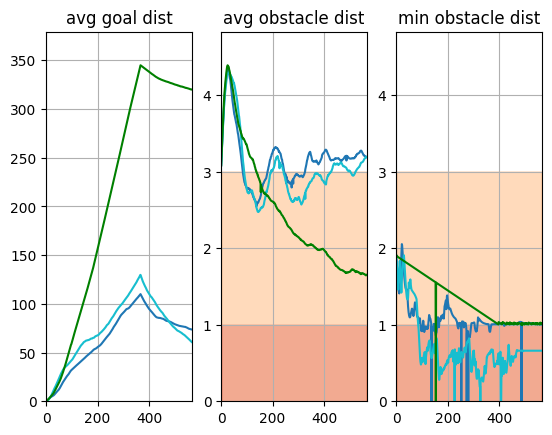

In [ ]:
def plot_eval_row(axs, total_df, color="blue"):
    avg_goal, avg_obst, min_obst = get_eval_arrays(total_df, max_index)
    axs[0].plot(avg_goal, color=color)
    axs[0].set_ylim(top = max(axs[0].get_ylim()[1], max(avg_goal) * 1.1))

    xs = list(range(max_index))
    alpha = 0.1

    axs[1].fill_between(xs, [3]*len(avg_obst), 0.0, linestyle="-", color="tab:orange", alpha=alpha)
    axs[1].fill_between(xs, [1]*len(avg_obst), 0.0, linestyle="-", color="tab:red", alpha=alpha)
    axs[1].plot(avg_obst, color=color)
    axs[1].set_ylim(top = max(axs[1].get_ylim()[1], max(avg_obst) * 1.1))

    axs[2].fill_between(xs, [3]*len(min_obst), 0.0, linestyle="-", color="tab:orange", alpha=alpha)
    axs[2].fill_between(xs, [1]*len(min_obst), 0.0, linestyle="-", color="tab:red", alpha=alpha)
    axs[2].plot(min_obst, color=color) 
    axs[2].set_ylim(top = axs[1].get_ylim()[1])
    for ax in axs:
        ax.set_ylim(bottom = 0.0)
        ax.set_xlim(0,max_index)
        ax.grid()

fig, ax_row = plt.subplots(1,3)
plot_eval_row(ax_row, long_Multi_PSO_df, "tab:blue")
plot_eval_row(ax_row, short_Multi_PSO_df, "tab:cyan")
plot_eval_row(ax_row, DWA_df, "green")
#ax_row[0].set_ylabel(kin_label)
ax_row[0].set_title("avg goal dist")
ax_row[1].set_title("avg obstacle dist")
ax_row[2].set_title("min obstacle dist")

plt.savefig("cluster_plot.png")

In [ ]:
df = pandas.read_hdf("data\Map Experiment #2\9\DWA_data.h5")
print(df)
max_index

          robo_x      robo_y  robo_deg      goal_x  goal_y   goal_dist  \
0.0    50.000000  300.000000  0.000000   50.000000   300.0    0.000000   
0.1    51.542745  299.996242 -0.004872   51.363636   300.0    0.179148   
0.2    53.018691  299.999993 -0.009533   52.727273   300.0    0.291418   
0.3    54.449510  300.010400 -0.014051   54.090909   300.0    0.358752   
0.4    55.960577  300.028028 -0.018823   55.454545   300.0    0.506807   
...          ...         ...       ...         ...     ...         ...   
56.3  279.024862  305.335500 -0.226861  550.000000   300.0  271.027660   
56.4  279.102567  305.357246 -0.134841  550.000000   300.0  270.950400   
56.5  279.183546  305.364430 -0.227553  550.000000   300.0  270.869579   
56.6  279.258533  305.385340 -0.138776  550.000000   300.0  270.795021   
56.7  279.340058  305.392869 -0.232144  550.000000   300.0  270.713663   

      obst_dist  
0.0    3.125000  
0.1    3.221422  
0.2    3.313668  
0.3    3.403094  
0.4    3.497536  
...

567